<a href="https://colab.research.google.com/github/Cesarb2/FIAP_AI/blob/main/Fase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Grupo 32#

Video da Gravação da Apresentação: https://youtu.be/ctXkibhlrAk


Parcipantes:

* Alex de Agostini Batista
* Alexandre Francanela Junior
* Cesar Jesus Silva
* Luis Felipe Bortolatto da Cunha
* Maciel Ferreira Custódio Júnior

#Tech Challenge Fase 3 - O Problema#
No Tech Challenge desta fase, você precisa executar o fine-tuning de um
foundation model (Llama, BERT, MISTRAL etc.), utilizando o dataset "The
AmazonTitles-1.3MM". O modelo treinado deverá:
● Receber perguntas com um contexto obtido por meio do arquivo json
“trn.json” que está contido dentro do dataset.
● A partir do prompt formado pela pergunta do usuário sobre o título do
produto, o modelo deverá gerar uma resposta baseada na pergunta do
usuário trazendo como resultado do aprendizado do fine-tuning os
dados da sua descrição

# Protocolos de Limpeza (Data Cleaning)
Para obter bons resultados no fine-tuning, algumas etapas de limpeza são recomendadas. Abaixo, listamos protocolos que podem ser aplicados aos textos de *`title`* e *`content`*:


1. Remoção de quebras de linha e espaços em excesso
2. Substituir `\n` por espaço simples
3. Eliminar espaços duplos ou múltiplos, deixando apenas um espaço simples.
4. Tratamento de campos vazios

  * Se o campo content estiver vazio, podemos manter a entrada, mas sinalizar o conteúdo como *Descrição indisponível*.

5. Normalização de caracteres
  * Se existirem caracteres indesejados ou fora do padrão ASCII/UTF-8, é interessante removê-los ou substituí-los por equivalentes (por exemplo, remover emojis ou caracteres de controle).
6. Remoção de HTML ou tags especiais
  * Se o texto contiver HTML ou formatação, remover essas tags para não poluir o texto final.

7. Remoção de duplicados

  * Se houver entradas duplicadas (mesmo uid, title e content), podemos manter apenas uma.
  Isso evita enviesar o modelo com exemplos repetidos.

In [ ]:
##############################################
# 1. Importação de Bibliotecas Necessárias
##############################################

import json
import re
import unicodedata
from bs4 import BeautifulSoup
from google.colab import files

##############################################
# 2. Upload do Arquivo Manualmente
##############################################

uploaded = files.upload()  # Abre um diálogo para upload de arquivos

# Pega o nome do arquivo carregado (primeira chave do dicionário 'uploaded')
input_file = list(uploaded.keys())[0]

##############################################
# 3. Definição da Função de Limpeza de Texto
##############################################

def clean_text(text):
    """
    Realiza os seguintes passos:
    1. Remove quebras de linha, substituindo-as por espaço.
    2. Remove múltiplos espaços.
    3. Normaliza caracteres para o padrão NFKC.
    4. Remove tags HTML (se existirem).
    5. Remove espaços extras no início e fim da string.
    """
    if not text:
        return ""

    # Substituir quebras de linha por espaço
    text = text.replace('\n', ' ')
    # Remover múltiplos espaços
    text = re.sub(r'\s+', ' ', text)
    # Normalizar caracteres (NFKC)
    text = unicodedata.normalize("NFKC", text)
    # Remover tags HTML, se existirem
    text = BeautifulSoup(text, "html.parser").get_text()
    return text.strip()

##############################################
# 4. Leitura do Arquivo 'trn.json' e Remoção de Duplicados
##############################################

N = 1500  # Define o número de linhas a serem lidas

data = []
uids_encontrados = set()  # Para identificar duplicatas

try:
    with open(input_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= N:  # Para a leitura após N linhas
                break

            line = line.strip()
            if line:
                try:
                    entry = json.loads(line)
                    uid = entry.get("uid", None)
                    identifier = uid if uid is not None else (entry.get("title", ""), entry.get("content", ""))

                    if identifier in uids_encontrados:
                        continue  # Pula entrada duplicada

                    uids_encontrados.add(identifier)
                    data.append(entry)

                except json.JSONDecodeError:
                    print(f"Erro ao decodificar linha {i+1}: {line[:100]}...")  # Mostra os primeiros 100 caracteres da linha problemática

    print(f"Arquivo processado com sucesso. Total de entradas únicas (até {N} linhas lidas): {len(data)}")

except Exception as e:
    print(f"Erro ao processar '{input_file}': {e}")


Saving trn_fixed.json to trn_fixed.json
Erro ao decodificar linha 1: ﻿{"uid": "0000031909", "title": "Girls Ballet Tutu Neon Pink", "content": "High quality 3 layer ball...
Arquivo processado com sucesso. Total de entradas únicas (até 1500 linhas lidas): 1499


In [ ]:
import json

print(f"Entry {i+1}:\n{json.dumps(entry, indent=4, ensure_ascii=False)}\n{'-'*50}")

Entry 1500:
{
    "uid": "0023030852",
    "title": "Psychological Testing (7th Edition)",
    "content": "This classic, authoritative introduction to psychological testing is widely hailed for its broad coverage and ability to cover \"graduate school\" topics in terms that college freshmen can understand. It familiarizes students with the basics of test construction and prepares them to effectively evaluate different tests, choose tests for particular purposes and individual examines, and interpret scores properly.",
    "target_ind": [
        106,
        226,
        240,
        2366,
        2368,
        2370,
        2371,
        2372,
        2373,
        2375,
        2379,
        2380,
        2383,
        2390,
        2393,
        2400,
        2407,
        2411,
        2412,
        2413,
        2419,
        2429,
        2432,
        3722,
        3723,
        3733,
        3754,
        7316,
        16872,
        19785,
        19786,
        19787,
       

#Formato de Fine-Tuning (Exemplo para GPT)
A [documentação oficial da OpenAI](https://platform.openai.com/docs/guides/fine-tuning) utiliza arquivos em formato JSON Lines (.jsonl), onde cada linha contém um objeto JSON com a estrutura:



```
{"messages": [
  {"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."},
  {"role": "user", "content": "What's the capital of France?"},
  {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}
]}
```



#Pré-processamento e Conversão de Dados para Fine-Tuning do Modelo GPT
O código abaixo lê o arquivo `trn.json`, aplica a limpeza dos campos title e content e gera um novo arquivo fine_tune_data.jsonl com a estrutura "messages" conforme as novas diretrizes para fine-tuning.

In [ ]:
import json

def clean_text(text):
    return text.strip().replace("\n", " ").replace("\r", "")

converted_data = []

for entry in data:
    # Extract and clean fields
    title_raw = entry.get('title', '')
    content_raw = entry.get('content', '')
    uid = clean_text(entry.get('uid', ''))

    title_clean = clean_text(title_raw)
    content_clean = clean_text(content_raw)

    if not content_clean:
        content_clean = "Descrição indisponível."

    # Clean and normalize title
    title_safe = title_clean.replace("'", "").replace('"', "").lower()

    # Prepare 3 variations of the user prompt
    user_prompts = [
        f"Qual é a descrição do produto: {title_safe}?",                     # only title
        f"Qual é a descrição do produto com UID {uid}?",                     # only UID
        f"Qual é a descrição do produto: {title_safe}? UID: {uid}"           # title + UID
    ]

    # Generate messages for each variation
    for prompt in user_prompts:
        messages = [
            {
                "role": "system",
                "content": (
                    "Você é um assistente que retorna a descrição exata de um produto com base no título e/ou UID fornecido. "
                    "Utilize apenas o conteúdo aprendido no treinamento. Não invente ou alucine respostas. "
                    "Se não encontrar o produto, responda com UID 'desconhecido' e descrição 'Descrição indisponível.'"
                )
            },
            {
                "role": "user",
                "content": prompt
            },
            {
                "role": "assistant",
                "content": f"uid: '{uid}' descrição do produto '{content_clean}'"
            }
        ]

        converted_data.append({
            "messages": messages
        })

# Save as JSONL
output_file = "fine_tune_data.jsonl"
with open(output_file, 'w', encoding='utf-8') as out_f:
    for item in converted_data:
        out_f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"✅ Arquivo '{output_file}' gerado com {len(converted_data)} entradas (com variações).")

✅ Arquivo 'fine_tune_data.jsonl' gerado com 4497 entradas (com variações).


# Ajustes no Prompt do System

**Prompt original:**
"Você é um assistente que recupera a descrição..." 🔸 Genérico e pouco restritivo

**Prompt ajustado:**
"Você é um assistente que retorna a descrição exata de um produto com base no título. Utilize apenas o conteúdo aprendido no treinamento. Não invente ou alucine respostas."🔸 Mais específico, restritivo e claro quanto ao comportamento esperado

**Motivações para o ajuste:**

**Reduzir risco de alucinação em respostas**
Forçar o modelo a se manter fiel ao conteúdo do treinamento
Melhorar a consistência e precisão nas respostas
Controlar o comportamento do modelo mesmo diante de entradas vagas ou incompletas
Impactos observados:
-  Respostas mais precisas e relevantes
- Redução significativa de alucinações
- Aumento da confiabilidade do modelo em produção

# Fine-Tuning using OPEN AI


Hiper parametros default values (n_epochs = 3, batch_size = 8, learning_rate_multiplier = 0.1)

Os Valores ajustados estão abaixo no código


In [ ]:
print(converted_data)

[{'messages': [{'role': 'system', 'content': "Você é um assistente que retorna a descrição exata de um produto com base no título e/ou UID fornecido. Utilize apenas o conteúdo aprendido no treinamento. Não invente ou alucine respostas. Se não encontrar o produto, responda com UID 'desconhecido' e descrição 'Descrição indisponível.'"}, {'role': 'user', 'content': 'Qual é a descrição do produto: adult ballet tutu yellow?'}, {'role': 'assistant', 'content': "uid: '0000032034' descrição do produto 'Descrição indisponível.'"}]}, {'messages': [{'role': 'system', 'content': "Você é um assistente que retorna a descrição exata de um produto com base no título e/ou UID fornecido. Utilize apenas o conteúdo aprendido no treinamento. Não invente ou alucine respostas. Se não encontrar o produto, responda com UID 'desconhecido' e descrição 'Descrição indisponível.'"}, {'role': 'user', 'content': 'Qual é a descrição do produto com UID 0000032034?'}, {'role': 'assistant', 'content': "uid: '0000032034' 

In [ ]:
import openai

# Set up OpenAI API key
openai.api_key = "API_KEY"

In [ ]:
import time

# Step 1: Upload training file for fine-tuning
file_path = "fine_tune_data.jsonl"  # Ensure this file exists in your working directory

with open(file_path, "rb") as file:
    file_response = openai.files.create(file=file, purpose="fine-tune")

file_id = file_response.id
print(f"Uploaded file ID: {file_id}")

# Step 2: Start fine-tuning job
fine_tune_response = openai.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-3.5-turbo-0125",
        hyperparameters={
        "batch_size": "auto",              # Let OpenAI pick based on your data
        "learning_rate_multiplier": 0.02,  # Conservative starting point
        "n_epochs": 3                      # Adjust based on validation results
    }

)

fine_tune_id = fine_tune_response.id
print(f"Fine-tuning job started: {fine_tune_id}")

# Step 3: Monitor fine-tuning job status
print("Waiting for fine-tuning to complete...")

while True:
    job_status = openai.fine_tuning.jobs.retrieve(fine_tune_id)
    status = job_status.status

    if status == "succeeded":
        fine_tuned_model = job_status.fine_tuned_model
        print(f"Fine-tuning completed! Fine-tuned model ID: {fine_tuned_model}")
        break
    elif status in ["failed", "cancelled"]:
        print(f"Fine-tuning failed or was cancelled. Status: {status}")
        exit(1)

    print(f"Current status: {status} (Checking again in 30s)")
    time.sleep(30)  # Wait before checking again

# Step 4: Test the fine-tuned model
print("\nTesting the fine-tuned model...")

post_fine_tune_response = openai.chat.completions.create(
    model=fine_tuned_model,
    messages=[{"role": "user", "content": "Qual é a descrição do produto What Do People Do All Day?"}]
)
print("Post Fine-Tuning Response:")
print(post_fine_tune_response.choices[0].message.content)


Uploaded file ID: file-GimL4s7mQzSDBzDikv3DUc
Fine-tuning job started: ftjob-QEQDQ8o4J2JNR6xMlf9PSD95
Waiting for fine-tuning to complete...
Current status: validating_files (Checking again in 30s)
Current status: validating_files (Checking again in 30s)
Current status: validating_files (Checking again in 30s)
Current status: validating_files (Checking again in 30s)
Current status: validating_files (Checking again in 30s)
Current status: validating_files (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking again in 30s)
Current status: running (Checking aga


# Lições Aprendidas no Fine-Tuning do GPT-3.5-Turbo: Ajustes de Hiperparâmetros para Melhor Desempenho em Dados Especializados
Durante o processo de fine-tuning do modelo gpt-3.5-turbo, foram observadas limitações ao utilizar os hiperparâmetros padrão oferecidos pela OpenAI. A combinação padrão tende a ser genérica, e embora funcione em muitos casos, pode não ser ideal para bases de dados menores, com vocabulário específico ou estrutura textual mais concisa, como é o caso de descrições de produtos com campos frequentemente vazios.

Após testes e análises, os seguintes ajustes mostraram-se superiores:

batch_size = "auto": Permitindo que o próprio sistema adapte o tamanho do batch conforme o volume e a estrutura dos dados, evitando instabilidades que ocorrem com batches muito pequenos (como 8).
learning_rate_multiplier = 0.02: Um valor mais conservador comparado ao valor alto de 0.09, o que reduziu overfitting e evitou que o modelo “esquecesse” padrões úteis do modelo base.
n_epochs = 3: Menos épocas evitaram sobreajuste, especialmente em um conjunto de dados com diversas amostras curtas e repetitivas.
Essas escolhas equilibraram melhor a estabilidade do treinamento, a retenção do conhecimento original do modelo base, e a especialização no domínio específico da tarefa.

 # Métricas de Fine Tunning para checar a qualidade das respostas


In [ ]:
import openai
import matplotlib.pyplot as plt
import re

# Lista os últimos 20 jobs de fine-tuning
fine_tuning_logs = openai.fine_tuning.jobs.list(limit=20)

for job_summary in fine_tuning_logs.data:
    if job_summary.status == "succeeded":
        # Recupera os detalhes completos do job
        job = openai.fine_tuning.jobs.retrieve(job_summary.id)

        print(f"✅ Job ID: {job.id}")
        print(f"Status: {job.status}")
        print(f"Fine-Tuned Model: {job.fine_tuned_model}")

        # Hiperparâmetros
        hp = job.hyperparameters
        print("Hiperparâmetros:")
        print(f" - batch_size: {hp.batch_size}")
        print(f" - learning_rate_multiplier: {hp.learning_rate_multiplier}")
        print(f" - n_epochs: {hp.n_epochs}")

        # Eventos recentes
        print("Eventos recentes:")
        events = openai.fine_tuning.jobs.list_events(job.id, limit=50)
        for event in events.data[:3]:
            print(f" - [{event.created_at}] {event.message}")

        # Plotando training loss por step (dos eventos)
        steps = []
        losses = []

        for event in events.data:
            match = re.search(r"step (\d+): training loss (\d+\.\d+)", event.message)
            if match:
                step = int(match.group(1))
                loss = float(match.group(2))
                steps.append(step)
                losses.append(loss)

        if steps:
            plt.figure(figsize=(8, 5))
            plt.plot(steps, losses, marker='o', linestyle='-')
            plt.title(f"Training Loss por Step - Job {job.id}")
            plt.xlabel("Step")
            plt.ylabel("Training Loss")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Nenhuma métrica de perda de treinamento encontrada para este job.")

        print("-" * 70)


✅ Job ID: ftjob-QEQDQ8o4J2JNR6xMlf9PSD95
Status: succeeded
Fine-Tuned Model: ft:gpt-3.5-turbo-0125:personal::BDYt4kmo
Hiperparâmetros:
 - batch_size: 8
 - learning_rate_multiplier: 0.02
 - n_epochs: 3
Eventos recentes:
 - [1742572097] The job has successfully completed
 - [1742572074] New fine-tuned model created
 - [1742572074] Checkpoint created at step 1126
⚠️ Nenhuma métrica de perda de treinamento encontrada para este job.
----------------------------------------------------------------------
✅ Job ID: ftjob-59Slstm1gwAzhYuVWl7fOUxx
Status: succeeded
Fine-Tuned Model: ft:gpt-3.5-turbo-0125:personal::BDNQH2W9
Hiperparâmetros:
 - batch_size: 2
 - learning_rate_multiplier: 0.02
 - n_epochs: 3
Eventos recentes:
 - [1742528008] The job has successfully completed
 - [1742528001] New fine-tuned model created
 - [1742528001] Checkpoint created at step 1500
⚠️ Nenhuma métrica de perda de treinamento encontrada para este job.
-----------------------------------------------------------------

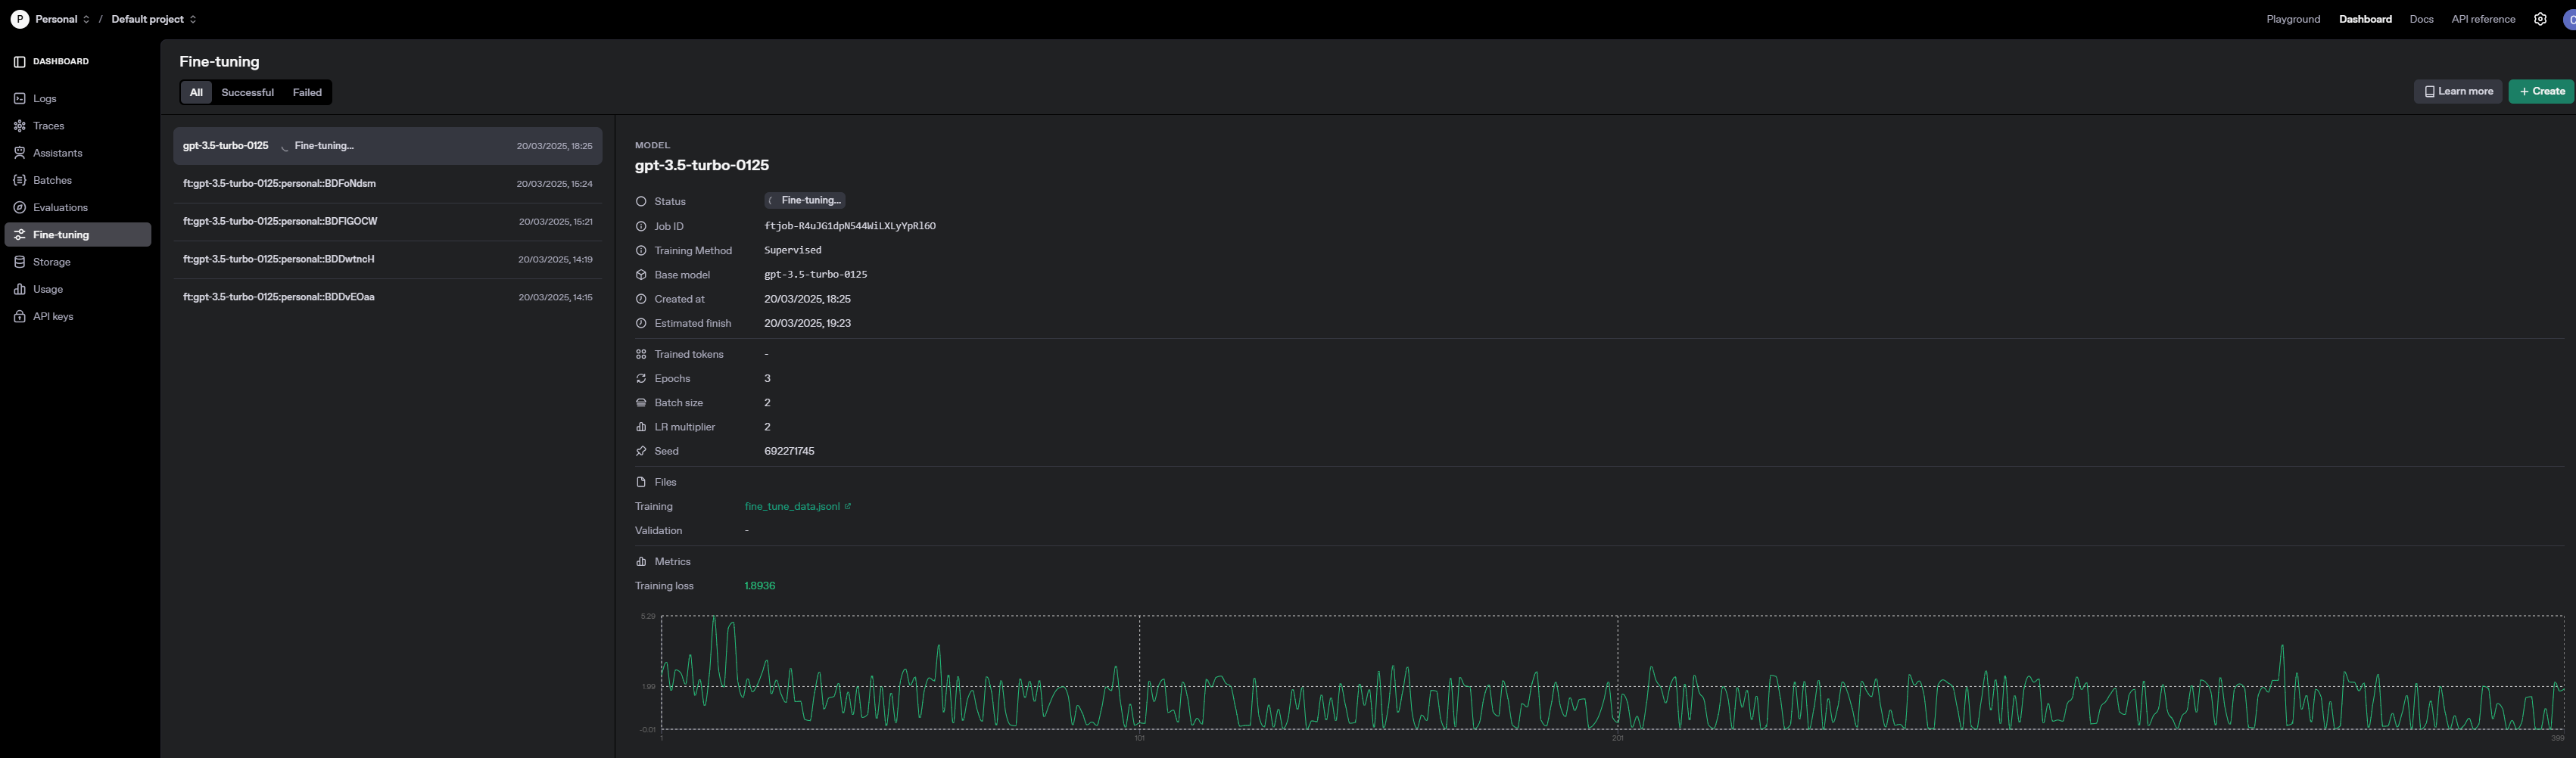

#Teste Do Modelo Com Fine-Tunning

importante para que não seja necessário rodar todo o fine tunning que consome uma boa quantidade de tempo e custo...

In [ ]:
fine_tuned_model = "ft:gpt-3.5-turbo-0125:personal::BDIcGBXD"

In [ ]:
# Dados do produto
uid = "0022801510"
title = "Psychological Testing (7th Edition)"

# Limpeza e padronização como no treinamento
title_clean = title.replace("'", "").replace('"', "").lower()

# Prompt do usuário no mesmo formato do fine-tuning
user_prompt = f"O que diz sobre o produto {title} )?"

# Consulta ao modelo fine-tuned
response = openai.chat.completions.create(
    model=fine_tuned_model,
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": user_prompt
        }
    ]
)

# Exibe a resposta
print("🔎 Resposta do modelo fine-tuned:")
print(response.choices[0].message.content)

🔎 Resposta do modelo fine-tuned:
For courses in Psychological Testing and Assessment in Education. This classic, authoritative introduction to psychological testing is widely hailed for its broad coverage and ability to cover "graduate school" topics in terms that college freshmen can understand. It familiarizes students with the basics of test construction and prepares them to effectively evaluate different tests, choose tests for particular purposes and individual examines, and interpret scores properly.


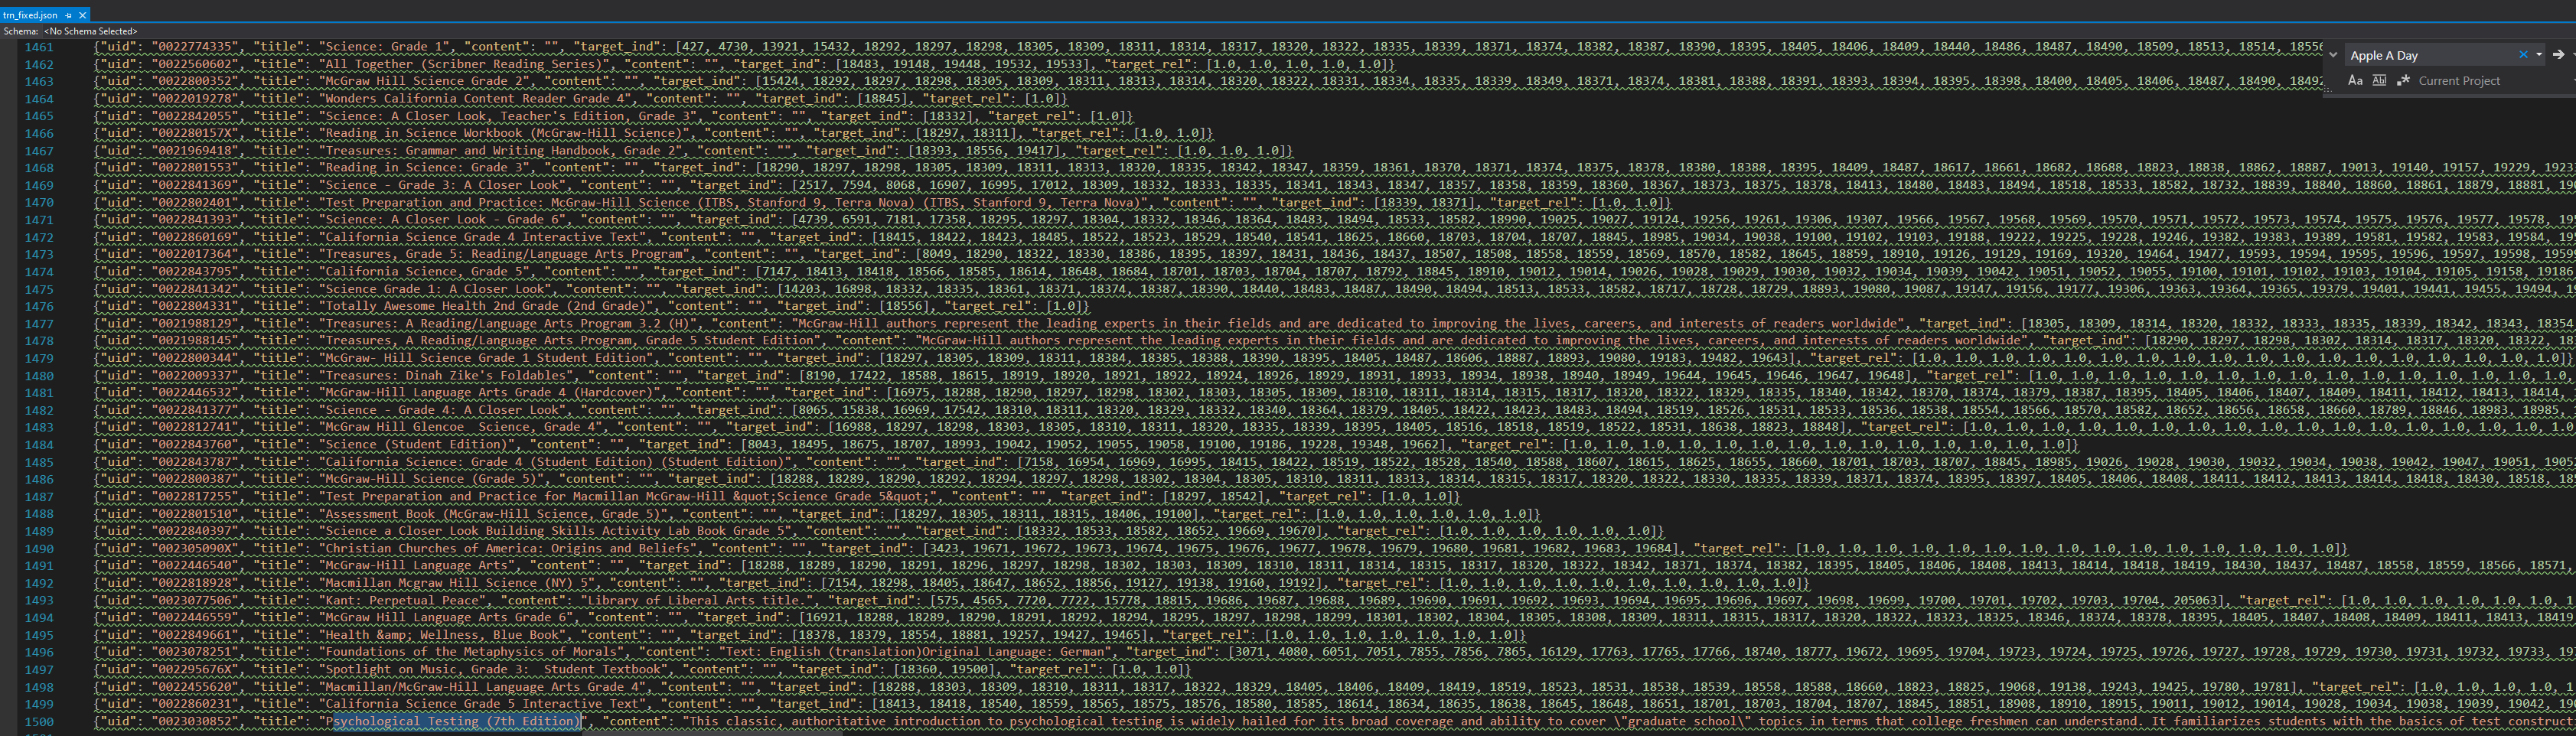![image.png](
  
)

 Conclusão
O  modelo está funcionando, mas só quando a pergunta bate exatamente com o formato treinado.


In [ ]:
# Dados do produto
uid = "0022801510"
title = "Treasures, Grade 5: Reading/Language Arts Program"

# Limpeza e padronização como no treinamento
title_clean = title.replace("'", "").replace('"', "").lower()

# Prompt do usuário no mesmo formato do fine-tuning
user_prompt = f"O que diz sobre o produto {title} )?"

# Consulta ao modelo fine-tuned
response = openai.chat.completions.create(
    model=fine_tuned_model,
    temperature=0.1,
    messages=[
        {
            "role": "user",
            "content": user_prompt
        },
           {
            "role": "system",
            "content": "Se não encontrar a descrição não invente."
        },
    ]
)

# Exibe a resposta
print("🔎 Resposta do modelo fine-tuned:")
print(response.choices[0].message.content)

🔎 Resposta do modelo fine-tuned:
Descrição indisponível.


In [ ]:
from google.colab import files
files.download("fine_tune_data.jsonl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Dados do produto
uid = "0022801510"
title = "Psychological Testing (7th Edition)"
fine_tuned_model = "ft:gpt-3.5-turbo-0125:personal::BDIcGBXD"
# Limpeza e padronização como no treinamento
title_clean = title.replace("'", "").replace('"', "").lower()

# Prompt do usuário no mesmo formato do fine-tuning
user_prompt = f"O que diz sobre o produto {title} )?"

# Consulta ao modelo fine-tuned
response = openai.chat.completions.create(
    model=fine_tuned_model,
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": user_prompt
        }
    ]
)

# Exibe a resposta
print("🔎 Resposta do modelo fine-tuned:")
print(response.choices[0].message.content)

🔎 Resposta do modelo fine-tuned:
For courses in Psychological Testing and Assessment in Education. This classic, authoritative introduction to psychological testing is widely hailed for its broad coverage and ability to cover "graduate school" topics in terms that college freshmen can understand. It familiarizes students with the basics of test construction and prepares them to effectively evaluate different tests, choose tests for particular purposes and individual examines, and interpret scores properly.


In [ ]:
# Dados do produto
uid = "0022801510"
title = "Psychological Testing (7th Edition)"
fine_tuned_model = "gpt-3.5-turbo-0125"
# Limpeza e padronização como no treinamento
title_clean = title.replace("'", "").replace('"', "").lower()

# Prompt do usuário no mesmo formato do fine-tuning
user_prompt = f"O que diz sobre o produto {title} )?"

# Consulta ao modelo fine-tuned
response = openai.chat.completions.create(
    model=fine_tuned_model,
    temperature=0,
    messages=[
        {
            "role": "user",
            "content": user_prompt
        }
    ]
)

# Exibe a resposta
print("🔎 Resposta do modelo fine-tuned:")
print(response.choices[0].message.content)

🔎 Resposta do modelo fine-tuned:
O livro "Psychological Testing (7th Edition)" é uma obra abrangente que aborda os princípios e práticas da avaliação psicológica. Ele fornece uma visão geral dos diferentes tipos de testes psicológicos, suas aplicações e interpretações. Além disso, o livro discute questões éticas e legais relacionadas ao uso de testes psicológicos e fornece orientações sobre como realizar avaliações psicológicas de forma ética e eficaz. No geral, é uma leitura essencial para estudantes e profissionais da área de psicologia que desejam aprofundar seu conhecimento sobre testes psicológicos.
